In [3]:
import numpy as np
import matplotlib.pyplot as plt
from MoreauYosida import MoreauYosida, MoreauYosidaOptimizer, soft_thresholding

# Set random seed for reproducibility
np.random.seed(42)



In [4]:
def plot_moreau_yosida_convergence():
    """
    Create a simple convergence plot for Moreau-Yosida optimizer with different gamma values.
    """
    # Create a LASSO problem (standard test case)
    n_samples, n_features = 50, 20
    X = np.random.randn(n_samples, n_features)
    true_w = np.zeros(n_features)
    true_w[:3] = [1.0, -0.5, 0.2]  # Sparse ground truth
    y = np.dot(X, true_w) + 0.01 * np.random.randn(n_samples)
    
    # Define the objective function
    # Smooth part (least squares)
    f_smooth = lambda w: 0.5 * np.sum((np.dot(X, w) - y) ** 2)
    grad_smooth = lambda w: np.dot(X.T, (np.dot(X, w) - y))
    
    # L1 regularization
    alpha = 0.1
    l1_func = lambda w: alpha * np.sum(np.abs(w))
    l1_prox = lambda w, t: soft_thresholding(w, alpha * t)
    
    # Initialize plot
    plt.figure(figsize=(12, 8))
    
    # Test different gamma values
    gamma_values = [0.5, 0.1, 0.01, 0.001]
    colors = ['blue', 'green', 'red', 'purple']
    
    for i, gamma in enumerate(gamma_values):
        # Create optimizer
        optimizer = MoreauYosidaOptimizer(
            f_smooth=f_smooth,
            grad_smooth=grad_smooth,
            g_func=l1_func,
            g_prox=l1_prox,
            gamma=gamma,
            max_iter=30,
            verbose=False
        )
        
        # Run optimization and track convergence
        x0 = np.zeros(n_features)
        _, trajectory = optimizer.optimize(x0, return_trajectory=True)
        
        # Calculate objective values
        objectives = [f_smooth(x) + l1_func(x) for x in trajectory]
        
        # Plot convergence
        plt.semilogy(range(len(objectives)), objectives, 
                    color=colors[i], linewidth=2, 
                    marker='o', markersize=6, 
                    label=f'γ = {gamma}')
    
    # Add gamma schedule curve
    def gamma_schedule(gamma, k):
        return gamma * 0.7**k if k > 0 else gamma
    
    optimizer_schedule = MoreauYosidaOptimizer(
        f_smooth=f_smooth,
        grad_smooth=grad_smooth,
        g_func=l1_func,
        g_prox=l1_prox,
        gamma=0.1,
        gamma_schedule=gamma_schedule,
        max_iter=30,
        verbose=False
    )
    
    _, trajectory_schedule = optimizer_schedule.optimize(x0, return_trajectory=True)
    objectives_schedule = [f_smooth(x) + l1_func(x) for x in trajectory_schedule]
    
    plt.semilogy(range(len(objectives_schedule)), objectives_schedule, 
                color='orange', linewidth=2, 
                marker='s', markersize=6, 
                label='Decreasing γ schedule')
    
    # Add labels and legend
    plt.title('Moreau-Yosida Optimizer Convergence', fontsize=16)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Objective Value (log scale)', fontsize=14)
    plt.grid(True, which="both", linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # Save figure
    plt.tight_layout()
    plt.savefig('moreau_yosida_convergence.png', dpi=300)
    plt.show()



In [5]:
def plot_nonsmooth_smoothing():
    """
    Visualize how Moreau-Yosida regularization smooths non-differentiable functions.
    """
    # Setup plot
    plt.figure(figsize=(14, 6))
    
    # Define a simple non-smooth function: absolute value
    def l1_norm(x):
        return np.abs(x)
    
    # Define proximal operator for L1 norm
    def l1_prox(x, t):
        return np.sign(x) * np.maximum(np.abs(x) - t, 0)
    
    # Generate x values for plotting
    x_values = np.linspace(-2, 2, 1000)
    
    # Plot original function
    l1_values = [l1_norm(x) for x in x_values]
    
    # Left plot: function values
    plt.subplot(1, 2, 1)
    plt.plot(x_values, l1_values, 'k-', linewidth=3, label='Original |x|')
    
    # Test different gamma values
    gamma_values = [0.5, 0.2, 0.1, 0.01]
    colors = ['blue', 'green', 'red', 'purple']
    
    for i, gamma in enumerate(gamma_values):
        # Create Moreau-Yosida smoothing
        my_smooth = MoreauYosida(l1_norm, l1_prox, gamma=gamma)
        
        # Compute smoothed values
        smooth_values = [my_smooth.value(np.array([x])) for x in x_values]
        
        # Plot smoothed function
        plt.plot(x_values, smooth_values, color=colors[i], linewidth=2, 
                label=f'γ = {gamma}')
    
    plt.title('Moreau-Yosida Smoothing of |x|', fontsize=16)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('Function Value', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    # Right plot: derivatives
    plt.subplot(1, 2, 2)
    
    # Subdifferential of |x|
    def l1_subgrad(x):
        if x > 0:
            return 1
        elif x < 0:
            return -1
        else:
            return 0  # Just one value in the subdifferential
    
    subgrad_values = [l1_subgrad(x) for x in x_values]
    plt.plot(x_values, subgrad_values, 'k-', linewidth=3, label='Subdifferential of |x|')
    
    # Plot smoothed gradients
    for i, gamma in enumerate(gamma_values):
        my_smooth = MoreauYosida(l1_norm, l1_prox, gamma=gamma)
        grad_values = [my_smooth.gradient(np.array([x]))[0] for x in x_values]
        
        plt.plot(x_values, grad_values, color=colors[i], linewidth=2, 
                label=f'γ = {gamma}')
    
    plt.title('Gradient Smoothing with Moreau-Yosida', fontsize=16)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('Gradient', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    # Save figure
    plt.tight_layout()
    plt.savefig('moreau_yosida_smoothing.png', dpi=300)
    plt.show()
    

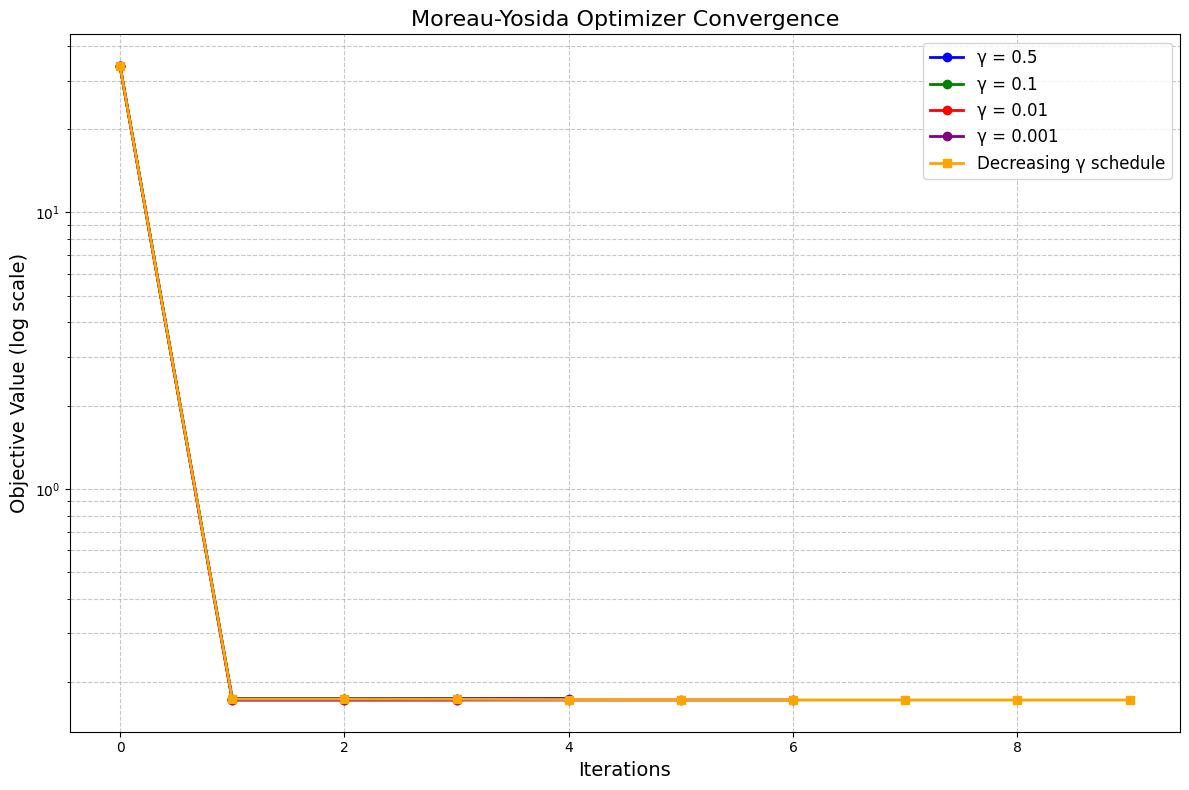

In [6]:
plot_moreau_yosida_convergence()

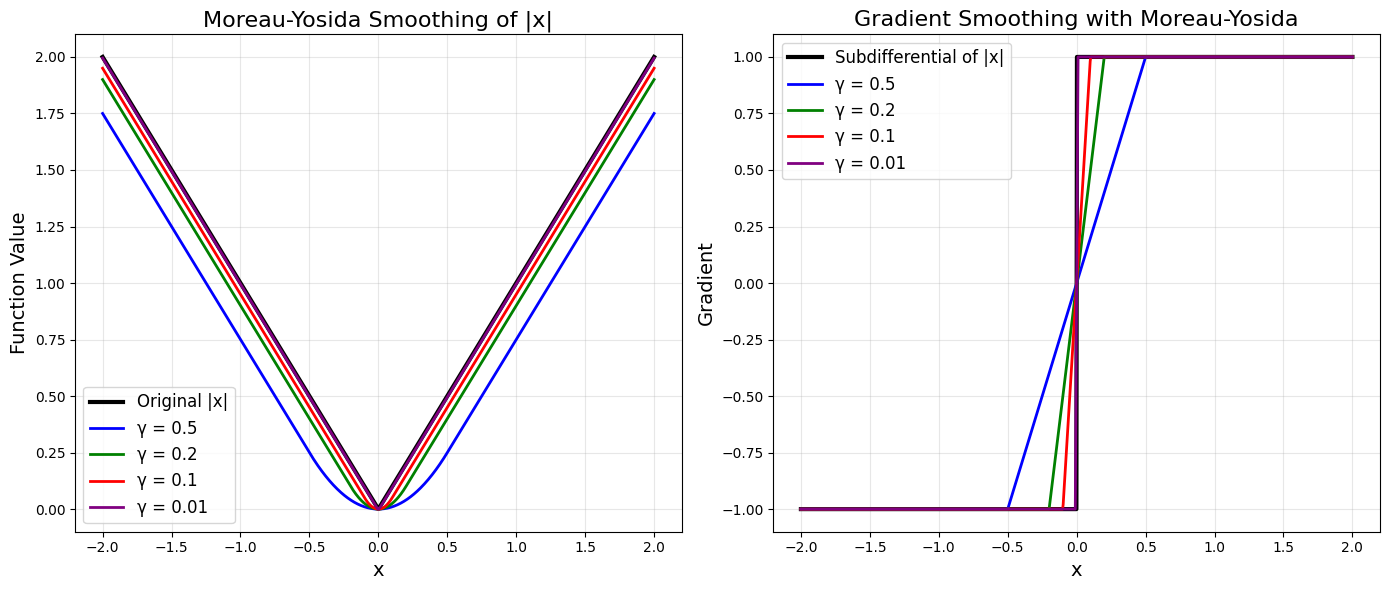

In [7]:
plot_nonsmooth_smoothing()